# Model spin-up and averaging time

In [1]:
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from modules import stats


In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46301,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:42101,Total threads: 1
Dashboard: http://127.0.0.1:33361/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:45415,


In [19]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/07_appendix/'
data_path = base_path + 'final_data/resolution_tests/1024x128/'
config_file = base_path + 'config/resolution_tests_low.yml'

with open(config_file, 'r') as f:
    config = yaml.load(f, yaml.Loader)
rayleigh = config['base']['parameters']['rayleigh']
prandtl = config['base']['parameters']['prandtl']


In [20]:
data = xr.open_mfdataset(
    data_path + '*.nc', chunks={'x': -1, 'z': -1, 't': 100})
data.theta


<xarray.DataArray 'theta' (t: 5001, x: 1024, z: 128)>
dask.array<concatenate, shape=(5001, 1024, 128), dtype=float64, chunksize=(100, 1024, 128), chunktype=numpy.ndarray>
Coordinates:
    sim_time      (t) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    wall_time     (t) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    timestep      (t) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    iteration     (t) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    write_number  (t) int64 dask.array<chunksize=(100,), meta=np.ndarray>
  * x             (x) float64 0.0 0.007812 0.01562 0.02344 ... 7.977 7.984 7.992
  * z             (z) float64 3.765e-05 0.0003388 0.0009409 ... 0.9997 1.0
  * t             (t) float64 0.0 0.2 0.4 0.6 0.8 ... 999.4 999.6 999.8 1e+03

In [21]:
nusselt = stats.nusselt_number(data, rayleigh, prandtl).compute()
rms_speed = stats.rms_speed(data).compute()
eps_k = stats.kinetic_dissipation(data, rayleigh, prandtl).compute()
eps_T = stats.thermal_dissipation(data, rayleigh, prandtl).compute()


In [22]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_T$': eps_T,
}


## Spin-up time

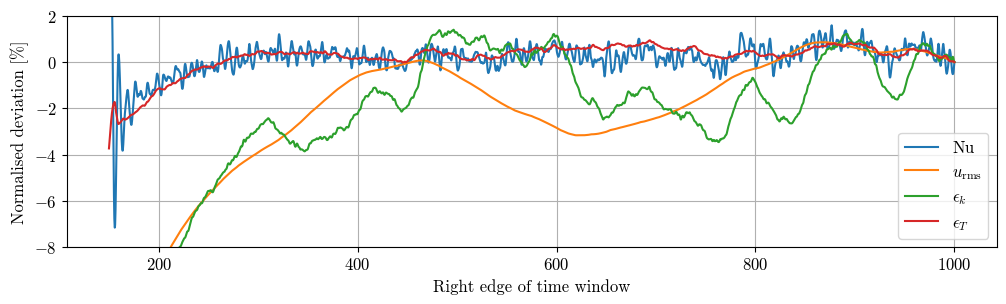

In [25]:
fig, ax = plt.subplots(figsize=(12, 3))

dt = (data.t[1] - data.t[0]).item()
window_t = 150.
window_n = round(window_t/dt/2)*2 + 1

for i, (name, var) in enumerate(metrics.items()):
    mean = var.rolling(t=window_n).mean()
    mean = (mean/mean.isel(t=-1) - 1)*100
    ax.plot(mean.t, mean, label=name)

ax.set(
    ylim=(-8, 2),
    xlabel='Right edge of time window',
    ylabel='Normalised deviation [%]',
)
ax.grid()
ax.legend(loc='lower right')
fig.savefig(fig_path + '1024x128_spin_up.pdf')


## Averaging time

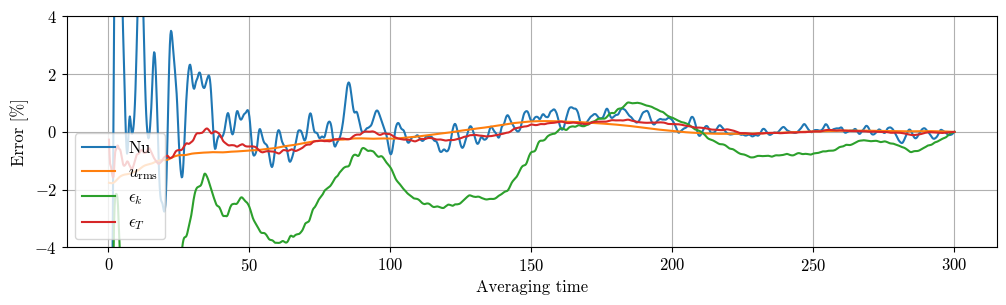

In [26]:
fig, ax = plt.subplots(figsize=(12, 3))
spin_up_time = 700.

for i, (name, var) in enumerate(metrics.items()):
    mean = stats.running_mean(var.isel(t=(var.t >= spin_up_time)), 't')
    mean = (mean/mean.isel(t=-1) - 1)*100
    ax.plot(mean.t - spin_up_time, mean, label=name)

ax.set(
    ylim=(-4, 4),
    xlabel='Averaging time',
    ylabel='Error [%]',
)
ax.grid()
ax.legend(loc='lower left')
fig.savefig(fig_path + '1024x128_averaging_time.pdf')


## Spin-up time for interpolated initial conditions

In [5]:
data_path = base_path + 'final_data/resolution_tests/2048x256/'


In [7]:
data = xr.open_mfdataset(
    data_path + '*.nc', chunks={'x': -1, 'z': -1, 't': 50})
data.theta


<xarray.DataArray 'theta' (t: 1751, x: 2048, z: 256)>
dask.array<concatenate, shape=(1751, 2048, 256), dtype=float64, chunksize=(50, 2048, 256), chunktype=numpy.ndarray>
Coordinates:
    sim_time      (t) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    wall_time     (t) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    timestep      (t) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    iteration     (t) int64 dask.array<chunksize=(50,), meta=np.ndarray>
    write_number  (t) int64 dask.array<chunksize=(50,), meta=np.ndarray>
  * x             (x) float64 0.0 0.003906 0.007812 ... 7.988 7.992 7.996
  * z             (z) float64 9.412e-06 8.471e-05 0.0002353 ... 0.9999 1.0
  * t             (t) float64 0.0 0.2 0.4 0.6 0.8 ... 349.4 349.6 349.8 350.0

In [8]:
nusselt = stats.nusselt_number(data, rayleigh, prandtl).compute()
rms_speed = stats.rms_speed(data).compute()
eps_k = stats.kinetic_dissipation(data, rayleigh, prandtl).compute()
eps_T = stats.thermal_dissipation(data, rayleigh, prandtl).compute()


In [9]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_T$': eps_T,
}


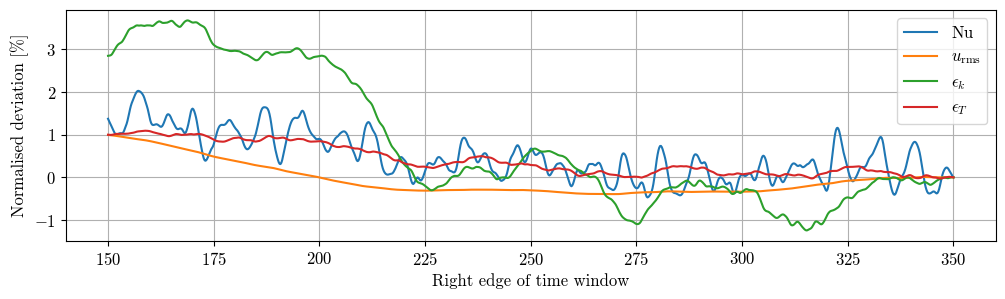

In [18]:
fig, ax = plt.subplots(figsize=(12, 3))

dt = (data.t[1] - data.t[0]).item()
window_t = 150.
window_n = round(window_t/dt/2)*2 + 1

for i, (name, var) in enumerate(metrics.items()):
    mean = var.rolling(t=window_n).mean()
    mean = (mean/mean.isel(t=-1) - 1)*100
    ax.plot(mean.t, mean, label=name)

ax.set(
    # ylim=(-8, 2),
    xlabel='Right edge of time window',
    ylabel='Normalised deviation [%]',
)
ax.grid()
ax.legend(loc='upper right')
fig.savefig(fig_path + '2048x256_spin_up.pdf')


In [47]:
client.close()
